In [22]:
## Import libraries
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit


import torch
from torch import nn
from torch.utils.data import TensorDataset

source = "../source"
sys.path.append(source)

from preprocessing import Encoding
from compilation import Compiler, ScalarTracker, ActivationTracker
import publication
import models

device = torch.device("cpu")

save = False

In [2]:
## Load settings
settings = "default"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)
    .loc[settings]
    .to_numpy()
)
model_type = getattr(models, model_type)

if nonlinearity == "none":
    nonlinearity = None
else:
    nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [3]:
lr = lr / 2
n_epochs = n_epochs * 2

In [4]:
## Generate data
input_dim, output_dim = in_dim, out_dim

inputs = np.array([[-1] * input_dim, [-1 + np.sqrt(dx2)] * input_dim]) / np.sqrt(
    input_dim
)
outputs = np.array([[0.6] * output_dim, [0.6 + np.sqrt(dy2)] * output_dim]) / np.sqrt(
    output_dim
)
names = ["A", "B"]
data = TensorDataset(
    torch.from_numpy(inputs.astype(np.float32)).to(device),
    torch.from_numpy(outputs.astype(np.float32)).to(device),
)

encoding = Encoding(dict(zip(names, inputs)))

train_datasets = [data]

tracked_datasets = train_datasets

In [5]:
## Instantiate model
model = model_type(
    input_size=input_dim,
    output_size=output_dim,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
    non_linearity=nonlinearity,
    encoding=encoding,
)

In [6]:
## Setup compiler
criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][hidden_layer], datasets=tracked_datasets
    ),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=tracked_datasets
    ),
}

In [7]:
## Training run
compiler.training_run(
    train_datasets,
    n_epochs=n_epochs,
    batch_size=100,
)

Training: 100%|██████████| 6000/6000 [02:09<00:00, 46.48steps/s, train_loss=0.00000, val_loss=0.00000]


In [8]:
## Get data
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()

loss = compiler.trackers["loss"].get_trace().copy()
train_loss = loss.groupby("Epoch").mean()
train_loss = train_loss.to_numpy().ravel()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()

h_A = [np.array(data.loc[epoch, 0, "A"]) for epoch, data in data_hid.groupby("Epoch")]
h_B = [np.array(data.loc[epoch, 0, "B"]) for epoch, data in data_hid.groupby("Epoch")]
y_A = [
    np.array(data.loc[epoch, 0, "A"]) for epoch, data in data_output.groupby("Epoch")
]
y_B = [
    np.array(data.loc[epoch, 0, "B"]) for epoch, data in data_output.groupby("Epoch")
]

y_true_A, y_true_B = outputs[0], outputs[1]
dy2 = np.sum((y_true_B - y_true_A) ** 2)
h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
w = np.array(
    [
        y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
        for epoch in epochs
    ]
)
y0_mean = np.sum((0.5 * ((y_A[0] + y_B[0]) - (y_true_B + y_true_A))) ** 2)

h0, y0, w0, dy = h2[0], y2[0], w[0], dy2

In [35]:
def fit(der):
    @njit
    def MSE_loss(t, z, eta_y_mean, dy2, y0_mean):
        """Mean squared loss for two datapoints."""
        L = (1 / 4) * (
            2 * np.exp(-2 * t * eta_y_mean) * y0_mean + z[2] + (1 / 2) * (dy2 - z[1])
        )
        return L

    def rep_sim(h0, y0, w0, dx2, dy2):
        """Return the representational distance of the two point system."""
        eta_h = 0.0001
        eta_y = eta_h * 1

        t_max = 100000

        sol = scipy.integrate.solve_ivp(
            der,
            [0, t_max],
            [h0, y0, w0],
            args=(eta_h, eta_y, dx2, dy2),
            dense_output=False,
        )

        z = sol.y[:, -1]
        return z[0]

    def optimize_eta(h2, y2, w, dx2, dy2, guesses=np.logspace(-6, 2, 200)):
        """Find the best fitting values for eta_h and eta_y."""
        h0, y0, w0 = h2[0], y2[0], w[0]
        n_epochs = len(h2)

        ratio = h2[-1] ** 2 / (dx2 * dy2)

        def model_accuracy(pars):
            eta_h, eta_y = pars

            t_max = n_epochs

            sol = scipy.integrate.solve_ivp(
                der,
                [0, t_max],
                [h0, y0, w0],
                args=(eta_h, eta_y, dx2, dy2),
                dense_output=True,
                method="Radau",
            )

            t = np.linspace(0, t_max, n_epochs)
            z = sol.sol(t)

            loss = (
                np.sum((h2 - z[0]) ** 2)
                + np.sum((y2 - z[1]) ** 2)
                + np.sum((w - z[2]) ** 2)
            )
            return loss

        # Find optimal etas
        guess = guesses[
            np.argmin(
                [model_accuracy(guess * np.array([ratio, 1])) for guess in guesses]
            )
        ]
        optimal = scipy.optimize.minimize(model_accuracy, guess * np.array([ratio, 1]))
        loss = optimal.fun
        eta_h_opt, eta_y_opt = optimal.x

        print(f"Loss: {loss}")

        return (eta_h_opt, eta_y_opt, loss)

    ## Fit effective learning rates
    eta_h_opt, eta_y_opt, loss = optimize_eta(
        h2, y2, w, dx2, dy2, guesses=np.logspace(-6, 2, 100)
    )

    sol = scipy.integrate.solve_ivp(
        der,
        [0, len(epochs)],
        [h0, y0, w0],
        args=(eta_h_opt, eta_y_opt, dx2, dy2),
        dense_output=True,
    )
    t = np.linspace(0, len(epochs), len(epochs))
    z = sol.sol(t)

    return t, z

In [36]:
@njit
def eff_theory(t, z, eta_h, eta_y, dx2, dy2):
    """Right hand side of the 3d ode system."""
    h, y, w = z
    return [
        -eta_h * dx2 * w,
        -w * (eta_y * h + eta_h * dx2 * y / h),
        -(1 / 2) * eta_y * (3 * w - y + dy2) * h
        - (1 / 2) * eta_h * dx2 * (y + w) * w / h,
    ]


@njit
def alt_1(t, z, eta_h, eta_y, dx2, dy2):
    """Right hand side of the 3d ode system."""
    h, y, w = z
    return [
        -eta_h * dx2 * w,
        -2 * w * (eta_y * h + eta_h * dx2 * y / h),
        -(1 / 2) * eta_y * (3 * w - y + dy2) * h
        - (1 / 2) * eta_h * dx2 * (y + w) * w / h,
    ]


@njit
def alt_2(t, z, eta_h, eta_y, dx2, dy2):
    """Right hand side of the 3d ode system."""
    h, y, w = z
    return [
        -eta_h * dx2 * w * 2,
        -w * (eta_y * h + eta_h * dx2 * y / h),
        -(1 / 2) * eta_y * (3 * w - y + dy2) * h
        - (1 / 2) * eta_h * dx2 * (y + w) * w / h,
    ]


@njit
def alt_3(t, z, eta_h, eta_y, dx2, dy2):
    """Right hand side of the 3d ode system."""
    h, y, w = z
    return [
        -eta_h * dx2 * w,
        -w * (eta_y * h + eta_h * dx2 * y / h),
        -(1 / 2) * eta_y * (3 * w - y + dy2) * h
        + (1 / 2) * eta_h * dx2 * (y + w) * w / h,
    ]


@njit
def alt_4(t, z, eta_h, eta_y, dx2, dy2):
    """Right hand side of the 3d ode system."""
    h, y, w = z
    return [
        -eta_h * dx2 * w,
        -w * (eta_y * h),
        -(1 / 2) * eta_y * (3 * w - y + dy2) * h
        - (1 / 2) * eta_h * dx2 * (y + w) * w / h,
    ]


alternative_dynamics = [eff_theory, alt_1, alt_2, alt_3, alt_4]

Loss: 0.9289631502356435


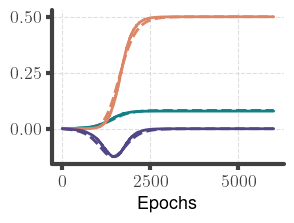

Loss: 15.349683504371166


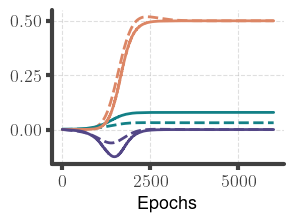

Loss: 16.611870165578765


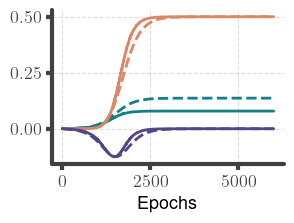

Loss: 2.9902842889995664


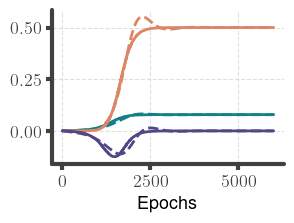

Loss: 5.637705423852344


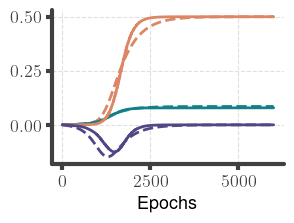

In [38]:
for dynamics in alternative_dynamics:

    t, z = fit(dynamics)

    traj_path = "plots/2_points/trajectories/"

    publication.set_color_mixed()
    figsize = (4, 3)

    # Plot 3-d dynamical system
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(t, z[0], linestyle="--")
    plt.plot(t, z[1], linestyle="--")
    plt.plot(t, z[2], linestyle="--")
    plt.gca().set_prop_cycle(None)
    ax.plot(t, h2, label="$||dh||^2$")
    ax.plot(t, y2, label="$||dy||^2$")
    ax.plot(t, w, label="$w$")
    # ax.legend()
    plt.xlabel("Epochs")
    if save:
        publication.plt_show(save_path=traj_path + "ode/" + settings + ".png")
    else:
        publication.plt_show()